In [1]:
# conda install -c rapidsai -c nvidia -c conda-forge dask-cuda cudatoolkit=11.6
# nvidia-smi
from sklearn.model_selection import train_test_split, KFold
import dask.dataframe as dd
import dask.multiprocessing
import dask
import numpy as np
from dask import delayed
import dask_image.imread
import dask_image.ndfilters
import dask_image.ndmeasure
import cv2
from glob import glob
import json
import dask.array as da
import time
import xgboost as xgb
import pandas as pd
import os
from dask import compute
from sklearn.metrics import f1_score
# f1_score(y_true, y_pred, average=[‘micro’, ‘macro’, ‘samples’,’weighted’ 중 하나 선택])
# import tensorflow as tf
from dask.distributed import Client, LocalCluster
from dask_cuda import LocalCUDACluster

path = os.getcwd()
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']
# from dask.distributed import Client, LocalCluster
# # client.close()
# cluster = LocalCluster()
# client = Client(cluster)
# print(cluster,client)
# client.close()
# http://localhost:8787/status

# from dask_cuda import LocalCUDACluster
# from dask.distributed import Client
# client.close()
# # http://127.0.0.1:34497/status
# cluster = LocalCUDACluster()
# client = Client(cluster)
# print(cluster,client)

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-01-29 16:46:04.091968: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-29 16:46:04.796754: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-29 16:46:04.796892: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-29 16:46:04.817119: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-29 16:46:04.817161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Laptop GPU computeCapability: 8.6
coreClock: 1.282GHz coreCount: 30 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 268.26GiB/s
2022-01-29 16:46:04.817183: I tensorflow/stream_exec

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10731566707714219437,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4844859392
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17212835513442772879
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"]

/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-29 16:46:05.243767: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1489] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2022-01-29 16:46:05.244112: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-29 16:46:05.244435: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-29 16:46:05.244465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/device:GPU:0 with 4620 MB memory) -> physical GPU (device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, comp

In [3]:
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'0':'정상','1':'초기','2':'중기','3':'말기'}


# #ensemble_labler
# label_description = {}
# for key, value in disease.items():
#     label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
#     for disease_code in value:
#         for risk_code in risk:
#             label = f'{key}_{disease_code}_{risk_code}'
#             label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'

label_description = {
"1_00_0" : "딸기", 
"2_00_0" : "토마토",
"2_a5_2" : "토마토_흰가루병_중기",
"3_00_0" : "파프리카",
"3_a9_1" : "파프리카_흰가루병_초기",
"3_a9_2" : "파프리카_흰가루병_중기",
"3_a9_3" : "파프리카_흰가루병_말기",
"3_b3_1" : "파프리카_칼슘결핍_초기",
"3_b6_1" : "파프리카_다량원소결필(N)_초기",
"3_b7_1" : "파프리카_다량원소결필(P)_초기",
"3_b8_1" : "파프리카_다량원소결필(K)_초기",
"4_00_0" : "오이",
"5_00_0" : "고추",
 "5_a7_2" : "고추_탄저병_중기",
 "5_b6_1" : "고추_다량원소결필(N)_초기",
"5_b7_1" : "고추_다량원소결필(P)_초기",
 "5_b8_1" : "고추_다량원소결필(K)_초기",
"6_00_0" : "시설포도",
"6_a11_1" : "시설포도_탄저병_초기",
 "6_a11_2" : "시설포도_탄저병_중기",
 "6_a12_1" : "시설포도_노균병_초기",
"6_a12_2" : "시설포도_노균병_중기",
 "6_b4_1" : "시설포도_일소피해_초기",
 "6_b4_3" : "시설포도_일소피해_말기",
"6_b5_1" : "시설포도_축과병_초기"   }


global ensemble_label_encoder
ensemble_label_encoder = {key:idx for idx, key in enumerate(label_description)}
ensemble_label_decoder = {val:key for key, val in ensemble_label_encoder.items()}

#crop_labler
crop_label_description = {}
for key, value in disease.items():
    crop_label_description[f'{key}'] = f'{crop[key]}'
    
global crop_label_encoder
crop_label_encoder = {key:idx for idx, key in enumerate(crop_label_description)}
crop_label_decoder = {val:key for key, val in crop_label_encoder.items()}


#disease_labler
disease_label_description = {}
for key, value in disease.items():
    disease_label_description[f'00'] = "정상"
    for disease_code,value in value.items():
        label = f'{disease_code}'
        disease_label_description[label] = f'{value}'

global disease_label_encoder
disease_label_encoder = {key:idx for idx, key in enumerate(disease_label_description)}
disease_label_decoder = {val:key for key, val in disease_label_encoder.items()}


#risk_labler
risk_label_description = {}
for key, value in risk.items():
    label = f'{key}'
    risk_label_description[label] = f'{value}'

global risk_label_encoder
risk_label_encoder = {key:idx for idx, key in enumerate(risk_label_description)}
risk_label_decoder = {val:key for key, val in risk_label_encoder.items()}





In [4]:
crop_label_description

{'1': '딸기', '2': '토마토', '3': '파프리카', '4': '오이', '5': '고추', '6': '시설포도'}

In [5]:
risk_label_description

{'0': '정상', '1': '초기', '2': '중기', '3': '말기'}

In [6]:
disease_label_description

{'00': '정상',
 'a1': '딸기잿빛곰팡이병',
 'a2': '딸기흰가루병',
 'b1': '냉해피해',
 'b6': '다량원소결핍 (N)',
 'b7': '다량원소결핍 (P)',
 'b8': '다량원소결핍 (K)',
 'a5': '토마토흰가루병',
 'a6': '토마토잿빛곰팡이병',
 'b2': '열과',
 'b3': '칼슘결핍',
 'a9': '파프리카흰가루병',
 'a10': '파프리카잘록병',
 'a3': '오이노균병',
 'a4': '오이흰가루병',
 'a7': '고추탄저병',
 'a8': '고추흰가루병',
 'a11': '시설포도탄저병',
 'a12': '시설포도노균병',
 'b4': '일소피해',
 'b5': '축과병'}

In [7]:
label_description

{'1_00_0': '딸기',
 '2_00_0': '토마토',
 '2_a5_2': '토마토_흰가루병_중기',
 '3_00_0': '파프리카',
 '3_a9_1': '파프리카_흰가루병_초기',
 '3_a9_2': '파프리카_흰가루병_중기',
 '3_a9_3': '파프리카_흰가루병_말기',
 '3_b3_1': '파프리카_칼슘결핍_초기',
 '3_b6_1': '파프리카_다량원소결필(N)_초기',
 '3_b7_1': '파프리카_다량원소결필(P)_초기',
 '3_b8_1': '파프리카_다량원소결필(K)_초기',
 '4_00_0': '오이',
 '5_00_0': '고추',
 '5_a7_2': '고추_탄저병_중기',
 '5_b6_1': '고추_다량원소결필(N)_초기',
 '5_b7_1': '고추_다량원소결필(P)_초기',
 '5_b8_1': '고추_다량원소결필(K)_초기',
 '6_00_0': '시설포도',
 '6_a11_1': '시설포도_탄저병_초기',
 '6_a11_2': '시설포도_탄저병_중기',
 '6_a12_1': '시설포도_노균병_초기',
 '6_a12_2': '시설포도_노균병_중기',
 '6_b4_1': '시설포도_일소피해_초기',
 '6_b4_3': '시설포도_일소피해_말기',
 '6_b5_1': '시설포도_축과병_초기'}

In [28]:

@delayed
def padding(data, array_len, col_len):
    pad = np.zeros((array_len, col_len))
    length = min(array_len, len(data))
    
    pad[:length] = data[:length]
    return pad

@delayed
def img_resize(img):
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32)/255
    return img


@delayed
def label_encoding(label):
    global ensemble_label_encoder
    encoded_label = ensemble_label_encoder[label]
    return encoded_label

@delayed
def label_encoding_crop(label):
    global crop_label_encoder
    encoded_label = crop_label_encoder[label]
    return encoded_label

@delayed
def label_encoding_disease(label):
    global disease_label_encoder
    encoded_label = disease_label_encoder[label]
    return encoded_label

@delayed
def label_encoding_risk(label):
    global risk_label_encoder
    encoded_label = risk_label_encoder[label]
    return encoded_label

def getlable(jsonpath,type):
    if type == "ensemble":
        with open(jsonpath, 'r') as f:
            json_file = json.load(f)

        crop = json_file['annotations']['crop']
        disease = json_file['annotations']['disease']
        risk = json_file['annotations']['risk']
        label = f'{crop}_{disease}_{risk}'
        return label

    elif type == "crop":
        with open(jsonpath, 'r') as f:
            json_file = json.load(f)
        crop = json_file['annotations']['crop']
        label = f'{crop}'
        return label

    elif type == "dc":
        with open(jsonpath, 'r') as f:
            json_file = json.load(f)
        disease = json_file['annotations']['disease']
        label = f'{disease}'
        return label

    elif type == "risk":  
        with open(jsonpath, 'r') as f:
            json_file = json.load(f)
        risk = json_file['annotations']['risk']
        label = f'{risk}'
        return label

    
def get_label_list(labelpath_list):
    labelarr = np.array([])
    labelarr_crop = np.array([])
    labelarr_dc = np.array([])
    labelarr_risk = np.array([])


    # labelarr = da.array([])
    for ind,json_path in enumerate(labelpath_list):
        # label = label_encoding(getlable(json_path))
        # label = da.array(np.array(label_encoding(getlable(json_path))))
        label = np.array(label_encoding(getlable(json_path,"ensemble")))
        labelarr = np.append(labelarr,label)

        label_crop = np.array(label_encoding_crop(getlable(json_path,"crop")))
        labelarr_crop = np.append(labelarr_crop,label_crop)

        label_dc = np.array(label_encoding_disease(getlable(json_path,"dc")))
        labelarr_dc = np.append(labelarr_dc,label_dc)

        label_risk = np.array(label_encoding_risk(getlable(json_path,"risk")))
        labelarr_risk = np.append(labelarr_risk,label_risk)


    return labelarr, labelarr_crop, labelarr_dc, labelarr_risk

@delayed
def imageresize(img):
    # img = dask.delayed(cv2.resize)(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    # img = dask.delayed(img.astype(np.float32)/255)  ##픽셀값을 0~1사이로 정규화
    # # img = np.transpose(img, (2,0,1))
    # return dask.delayed(img.reshape)(-1,224,224,3)
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32)/255  ##픽셀값을 0~1사이로 정규화
    # img = np.transpose(img, (2,0,1))
    return np.array(img)

@delayed
def imageresize2(img):
    # img = dask.delayed(cv2.resize)(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    # img = dask.delayed(img.astype(np.float32)/255)  ##픽셀값을 0~1사이로 정규화
    # # img = np.transpose(img, (2,0,1))
    # return dask.delayed(img.reshape)(-1,224,224,3)
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    # img = img.astype(np.float32)/255  ##픽셀값을 0~1사이로 정규화
    # img = np.transpose(img, (2,0,1))
    return np.array(img)

In [29]:
@delayed
def get_all_image(imgpath_list,image_size):
    imgarr = np.empty((0,image_size,image_size,3), float)
    for ind,img_path in enumerate(imgpath_list):
        imgarr = delayed(np.append)(imgarr,img, axis = 0)
    return imgarr

In [30]:
%%time
label_list = sorted(glob(os.path.join(path,"data","train","*","*.json")))
y_train,y_train_crop,y_train_dc,y_train_risk, = get_label_list(label_list)
# y_train = y_train.rechunk(5767)
results = dask.compute(*y_train)
label = np.array(results)
# print(label.shape)
results_crop = dask.compute(*y_train_crop)
label_crop = np.array(results_crop)
#
results_dc = dask.compute(*y_train_dc)
label_disease = np.array(results_dc)
#
results_risk = dask.compute(*y_train_risk)
label_risk = np.array(results_risk)
label.shape,label_crop.shape,label_disease.shape,label_risk.shape

CPU times: user 4.12 s, sys: 156 ms, total: 4.28 s
Wall time: 4.18 s


((5767,), (5767,), (5767,), (5767,))

In [31]:
%%time
#making_img_set
row_img = dask_image.imread.imread(os.path.join(path,"data","train","*","*.jpg"))
train = [imageresize2(img) for img in row_img]
train_x = da.array(dask.compute(*train))
# os.path.join(path,"data","train","*","*.jpg")


CPU times: user 45.7 s, sys: 3.32 s, total: 49 s
Wall time: 15.3 s


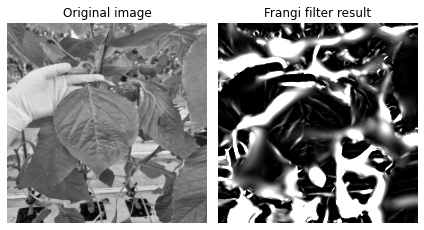

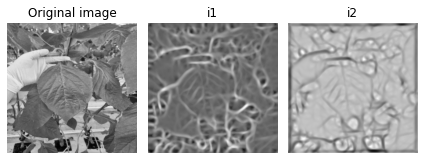

In [32]:
from skimage.filters import frangi
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# image = camera()
image = train_x[0].compute()[:,:,1]
plt.close('all')

fig, ax = plt.subplots(ncols=2)

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(
    frangi(image),
    cmap=plt.cm.gray, vmin = 0, vmax = 0.00001)
ax[1].set_title('Frangi filter result')

for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

#%% Hessian의 Eigen value만 plot

from skimage.feature import hessian_matrix, hessian_matrix_eigvals

hessall = hessian_matrix(image, sigma = 3)
hxx, hxy, hyy = hessall[0],hessall[1],hessall[2]

i1, i2 = hessian_matrix_eigvals([hxx, hxy, hyy])

plt.close('all')
fig, ax = plt.subplots(ncols=3)

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(i1, cmap = plt.cm.gray)
ax[1].set_title('i1')

ax[2].imshow(i2, cmap = plt.cm.gray)
ax[2].set_title('i2')


for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

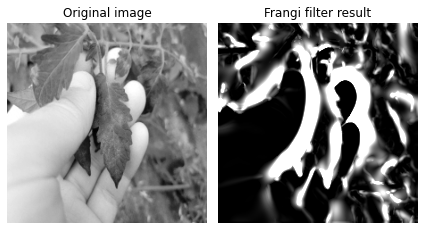

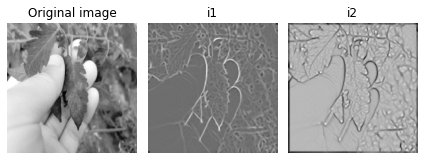

In [33]:
from skimage.filters import frangi
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# image = camera()
image = train_x[150].compute()[:,:,0]
plt.close('all')

fig, ax = plt.subplots(ncols=2)

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(
    frangi(image),
    cmap=plt.cm.gray, vmin = 0, vmax = 0.00001)
ax[1].set_title('Frangi filter result')

for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

#%% Hessian의 Eigen value만 plot

from skimage.feature import hessian_matrix, hessian_matrix_eigvals

hessall = hessian_matrix(image, sigma = 1)
hxx, hxy, hyy = hessall[0],hessall[1],hessall[2]

i1, i2 = hessian_matrix_eigvals([hxx, hxy, hyy])

plt.close('all')
fig, ax = plt.subplots(ncols=3)

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(i1, cmap = plt.cm.gray)
ax[1].set_title('i1')

ax[2].imshow(i2, cmap = plt.cm.gray)
ax[2].set_title('i2')


for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

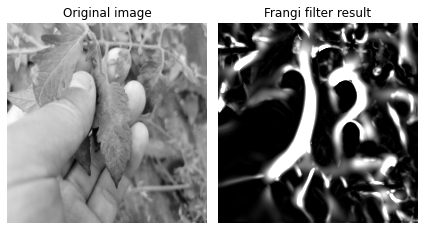

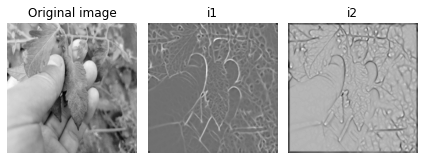

In [34]:
from skimage import color
from skimage import io
from skimage.filters import frangi
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# image = camera()
image = train_x[150].compute()[:,:,:]
image = color.rgb2gray(image)
plt.close('all')

fig, ax = plt.subplots(ncols=2)

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(
    frangi(image),
    cmap=plt.cm.gray, vmin = 0, vmax = 0.00001)
ax[1].set_title('Frangi filter result')

for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

#%% Hessian의 Eigen value만 plot

from skimage.feature import hessian_matrix, hessian_matrix_eigvals

hessall = hessian_matrix(image, sigma = 1)
hxx, hxy, hyy = hessall[0],hessall[1],hessall[2]

i1, i2 = hessian_matrix_eigvals([hxx, hxy, hyy])

plt.close('all')
fig, ax = plt.subplots(ncols=3)

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(i1, cmap = plt.cm.gray)
ax[1].set_title('i1')

ax[2].imshow(i2, cmap = plt.cm.gray)
ax[2].set_title('i2')


for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

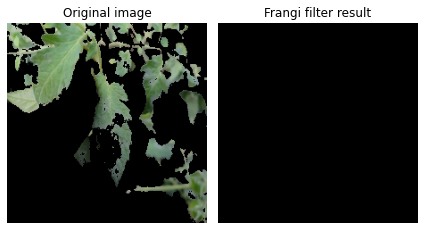

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


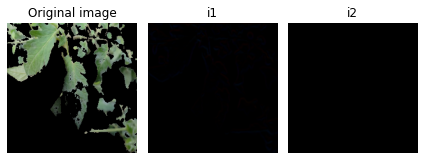

In [50]:


from skimage import color
from skimage import io
from skimage.filters import frangi
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# image = camera()
image = train_x[150].compute()[:,:,:]
# image = color.rgb2gray(image)

height, width = image.shape[:2] # 이미지의 높이와 너비 불러옴, 가로 [0], 세로[1]

img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # cvtColor 함수를 이용하여 hsv 색공간으로 변환

lower_blue = (30, 30, 30) # hsv 이미지에서 바이너리 이미지로 생성 , 적당한 값 30
upper_blue = (100, 255, 255)
img_mask = cv2.inRange(img_hsv, lower_blue, upper_blue) # 범위내의 픽셀들은 흰색, 나머지 검은색

image = cv2.bitwise_and(image, image, mask = img_mask) 
# image = cv2.bitwise_and(image, image)


plt.close('all')

fig, ax = plt.subplots(ncols=2)

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(
    frangi(image),
    cmap=plt.cm.gray, vmin = 0, vmax = 0.00001)
ax[1].set_title('Frangi filter result')

for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

#%% Hessian의 Eigen value만 plot

from skimage.feature import hessian_matrix, hessian_matrix_eigvals

hessall = hessian_matrix(image, sigma = 1)
hxx, hxy, hyy = hessall[0],hessall[1],hessall[2]

i1, i2 = hessian_matrix_eigvals([hxx, hxy, hyy])

plt.close('all')
fig, ax = plt.subplots(ncols=3)

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(i1, cmap = plt.cm.gray)
ax[1].set_title('i1')

ax[2].imshow(i2, cmap = plt.cm.gray)
ax[2].set_title('i2')


for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

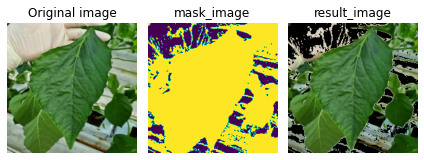

In [64]:

from skimage import color
from skimage import io
from skimage.filters import frangi
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# image = camera()
image = train_x[110].compute()[:,:,:]
# image = color.rgb2gray(image)

height, width = image.shape[:2] # 이미지의 높이와 너비 불러옴, 가로 [0], 세로[1]

img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # cvtColor 함수를 이용하여 hsv 색공간으로 변환

lower_blue = (30, 30, 30) # hsv 이미지에서 바이너리 이미지로 생성 , 적당한 값 30
upper_blue = (100, 255, 255)
img_mask = cv2.inRange(img_hsv, lower_blue, upper_blue) # 범위내의 픽셀들은 흰색, 나머지 검은색

img_result = cv2.bitwise_and(image, image, mask = img_mask) 
# image = cv2.bitwise_and(image, image)


plt.close('all')

fig, ax = plt.subplots(ncols=3)

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(img_mask)
ax[1].set_title('mask_image')

ax[2].imshow(img_result)
ax[2].set_title('result_image')

for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

# cv2.imshow('img_color', image)
# cv2.imshow('img_mask', img_mask)
# cv2.imshow('img_color', img_result)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [65]:
img_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)